In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

C:\Users\fran_\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Weather', 'Total Consumers'])
data.keys()

dict_keys(['Weather', 'Total Consumers'])

In [4]:
df_weather = data['Weather']
df_tc = data['Total Consumers']
df_weather

,datetime,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2
0,2019-01-01 00:15:00.000,8,4,1030,5,7,76,0,0,0
1,2019-01-01 00:30:00.000,8,4,1030,3,6,76,0,0,0
2,2019-01-01 00:45:00.000,8,4,1030,4,6,78,0,0,0
3,2019-01-01 01:00:00.000,8,4,1030,3,6,78,0,0,0
4,2019-01-01 01:15:00.000,8,4,1030,2,8,78,0,0,0
...,...,...,...,...,...,...,...,...,...,...
35034,NaN,0,0,0,0,0,0,0,0,0
35035,NaN,0,0,0,0,0,0,0,0,0
35036,NaN,0,0,0,0,0,0,0,0,0
35037,NaN,0,0,0,0,0,0,0,0,0


In [5]:
df_weather.isnull().sum()

datetime                  22953
TemperatureC                  0
DewpointC                     0
PressurehPa                   0
WindSpeedKMH                  0
WindSpeedGustKMH              0
Humidity                      0
HourlyPrecipMM                0
dailyrainMM                   0
SolarRadiationWatts_m2        0
dtype: int64

In [6]:
df_energy = df_tc[0]
df_energy

0        2.964
1        2.584
2        3.071
3        2.694
4        2.569
         ...  
35131    1.664
35132    1.659
35133    1.664
35134    1.697
35135    1.673
Name: 0, Length: 35136, dtype: float64

In [7]:
# Drop NaN values from weather dataset
df_weather.dropna(axis=0, inplace=True)
df_weather.reset_index(drop=True, inplace=True)

# Remove Datetime because XGB doesn't allow categorical variables
df_weather_no_date = df_weather.drop('datetime', axis=1, inplace=False)
df_weather_no_date

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2
0,8,4,1030,5,7,76,0,0,0
1,8,4,1030,3,6,76,0,0,0
2,8,4,1030,4,6,78,0,0,0
3,8,4,1030,3,6,78,0,0,0
4,8,4,1030,2,8,78,0,0,0
...,...,...,...,...,...,...,...,...,...
12081,12,8,1017,11,19,76,0,0,0
12082,12,8,1016,11,17,76,0,0,0
12083,12,8,1016,4,12,76,0,0,0
12084,12,8,1016,3,14,76,0,0,0


In [8]:
# Transform energy dataset to be the same size as the weather one
df_energy_new = df_energy[0:df_weather.shape[0]]
X = df_weather_no_date
y = df_energy_new
df_energy_new

0        2.964
1        2.584
2        3.071
3        2.694
4        2.569
         ...  
12081    3.115
12082    2.596
12083    2.903
12084    2.789
12085    2.844
Name: 0, Length: 12086, dtype: float64

## Plot some data

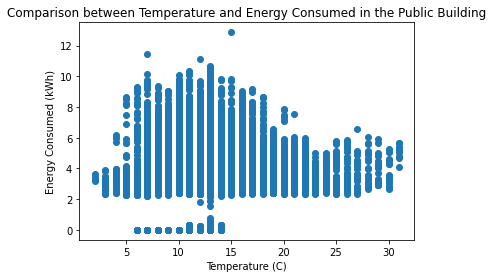

In [9]:
plt.scatter(X['TemperatureC'], y)
plt.xlabel('Temperature (C)') 
plt.ylabel('Energy Consumed (kWh)')
plt.title('Comparison between Temperature and Energy Consumed in the Public Building')
plt.show()

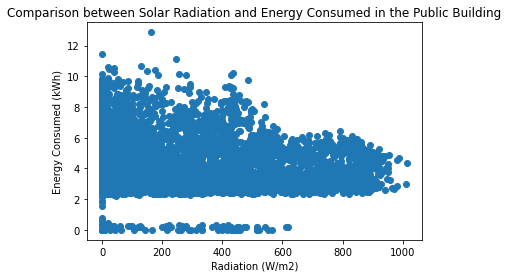

In [10]:
plt.scatter(X['SolarRadiationWatts_m2'], y)
plt.xlabel('Radiation (W/m2)') 
plt.ylabel('Energy Consumed (kWh)')
plt.title('Comparison between Solar Radiation and Energy Consumed in the Public Building')
plt.show()

## Auxiliary functions

In [11]:
def build_model(X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return model, preds


def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    wmape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('RMSE: %.4f' % rmse)
    print('MAE: %.4f' % mae)
    print('WMAPE: %.4f' % wmape)
    print('R2: %.4f' % r2)

### First Model (all weather features)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model, preds = build_model(X_train, y_train, X_test)

C:\Users\fran_\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


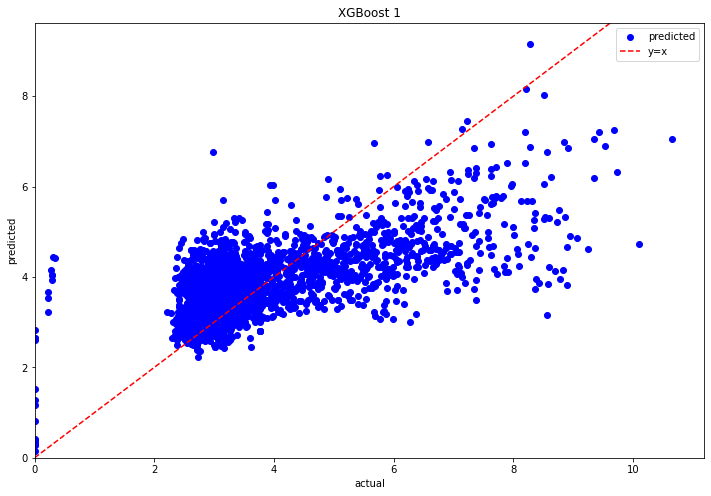

In [13]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 1')

In [14]:
performance_metrics(preds, y_test.values.reshape(-1))

MSE: 1.2537
RMSE: 1.1197
MAE: 0.8132
WMAPE: 21.3596
R2: 0.4335


### Second Model (all weather features + last 24 hours)

In [15]:
y2 = df_energy_new

# Concatenate with energy consumed
X2 = pd.concat([df_weather_no_date, y2], axis=1) 

X2.rename(columns = {0:'Energy'}, inplace = True)
X2
#X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Energy
0,8,4,1030,5,7,76,0,0,0,2.964
1,8,4,1030,3,6,76,0,0,0,2.584
2,8,4,1030,4,6,78,0,0,0,3.071
3,8,4,1030,3,6,78,0,0,0,2.694
4,8,4,1030,2,8,78,0,0,0,2.569
...,...,...,...,...,...,...,...,...,...,...
12081,12,8,1017,11,19,76,0,0,0,3.115
12082,12,8,1016,11,17,76,0,0,0,2.596
12083,12,8,1016,4,12,76,0,0,0,2.903
12084,12,8,1016,3,14,76,0,0,0,2.789


### Third Model (all weather features + last 7 days)

## Feature Importance

In [16]:
model.feature_importances_

array([0.12562646, 0.12005223, 0.14263792, 0.03783444, 0.09688658,
       0.11704353, 0.03941116, 0.201799  , 0.1187087 ], dtype=float32)

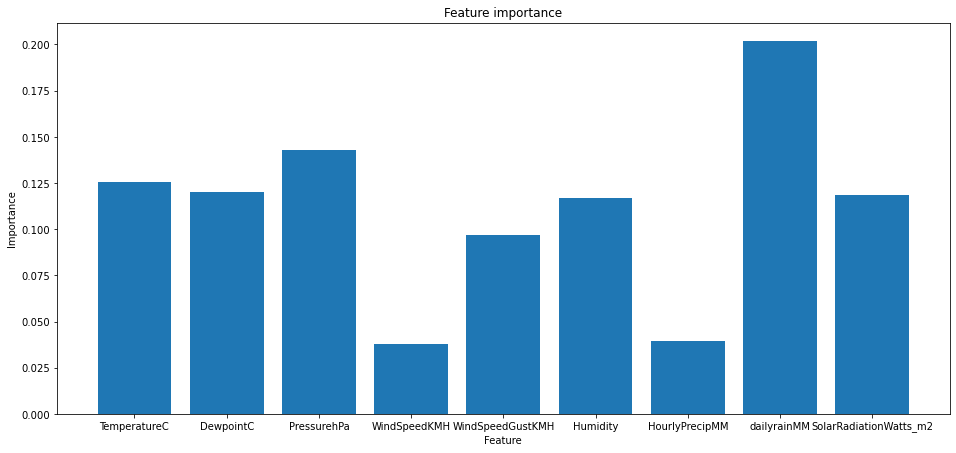

In [21]:
time_importance = model.feature_importances_

plt.figure(figsize=(16, 7.2))
plt.bar(X.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()